In [ ]:
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub 
import matplotlib.pyplot as plt
from PIL import ImageDraw
from PIL import Image
from PIL import ImageFont
from PIL import ImageOps
from PIL import ImageColor
import tempfile
from six import BytesIO
from six.moves.urllib.request import urlopen

In [ ]:

def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename

In [ ]:


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [ ]:
url = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(url).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Image downloaded to /tmp/tmptupba3l1.jpg.


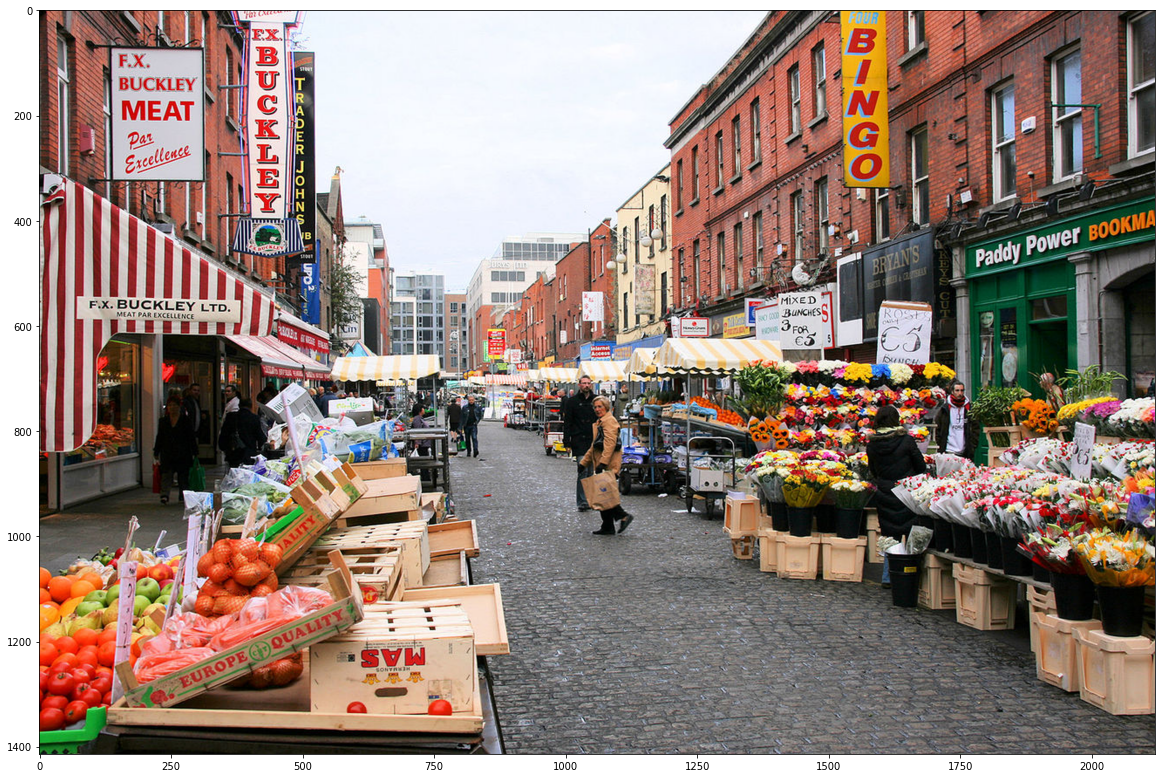

In [ ]:

img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Moore_Street_market%2C_Dublin.jpg/1280px-Moore_Street_market%2C_Dublin.jpg"
width  = 2122
height = 1414
downloaded_image_path = download_and_resize_image(img_url, width, height,display=True)

In [ ]:
print('Image Path: ',downloaded_image_path)

Image Path:  /tmp/tmptupba3l1.jpg


In [ ]:
def load_img(image_path):
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img,channels=3)
  return img

In [ ]:
img_dublin = load_img(downloaded_image_path)
img_dublin_predict = tf.image.convert_image_dtype(img_dublin,tf.float32)[tf.newaxis,...]
result = detector(img_dublin_predict)

In [ ]:
r = {key:value.numpy() for key,value in result.items()}
print('Type of result :',type(result))
print('keys',result.keys())

Type of result : <class 'dict'>
keys dict_keys(['detection_class_names', 'detection_boxes', 'detection_scores', 'detection_class_labels', 'detection_class_entities'])


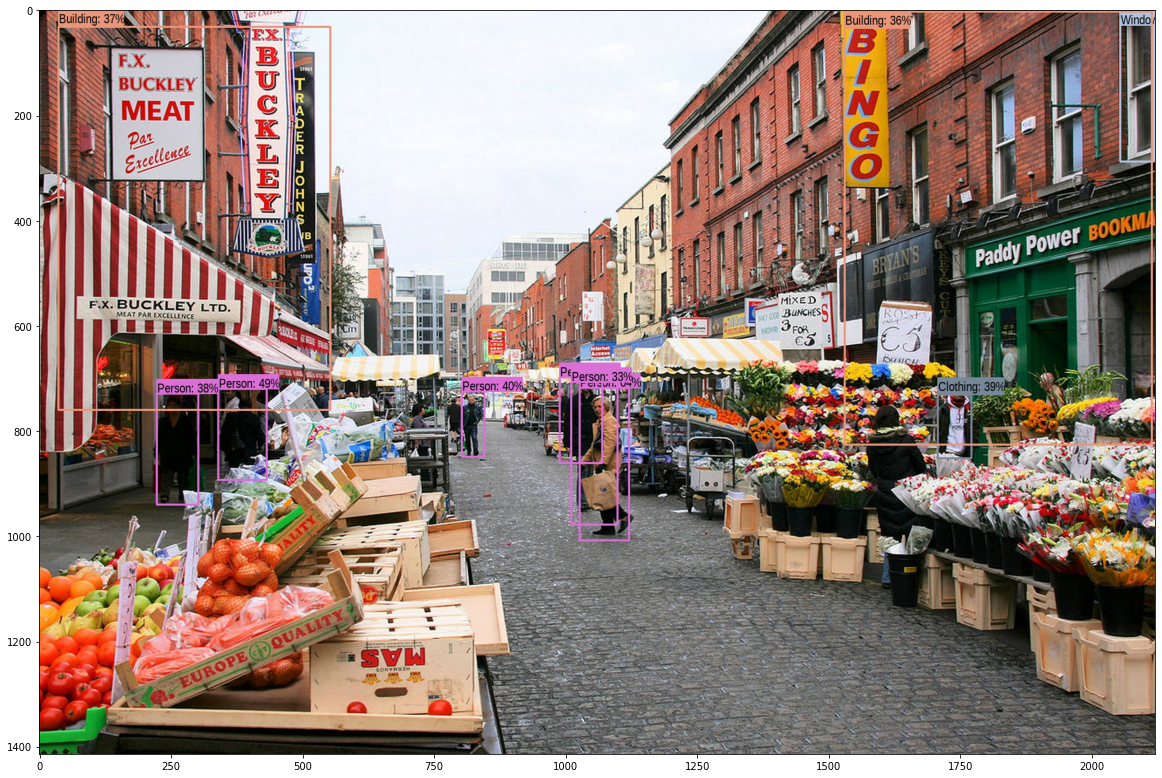

In [ ]:
img_dublin_box = draw_boxes(img_dublin.numpy(),r['detection_boxes'],r['detection_class_entities'],r['detection_scores'])
display_image(img_dublin_box)

In [ ]:
def predict_image(image_url,width=256,height=256,show_img=True,max_boxes=10):
  downloaded_image_path = download_and_resize_image(img_url,width,height)
  img = load_img(downloaded_image_path)
  img_prediction = tf.image.convert_image_dtype(img,tf.float32)[tf.newaxis,...]
  result = detector(img_prediction)
  result = {key:value.numpy() for key,value in result.items()}
  img_box = draw_boxes(img.numpy(),r['detection_boxes'],r['detection_class_entities'],r['detection_scores'],max_boxes=max_boxes)
  if show_img:
    display_image(img_box)
  return img_box


Image downloaded to /tmp/tmpqj1dcpsx.jpg.


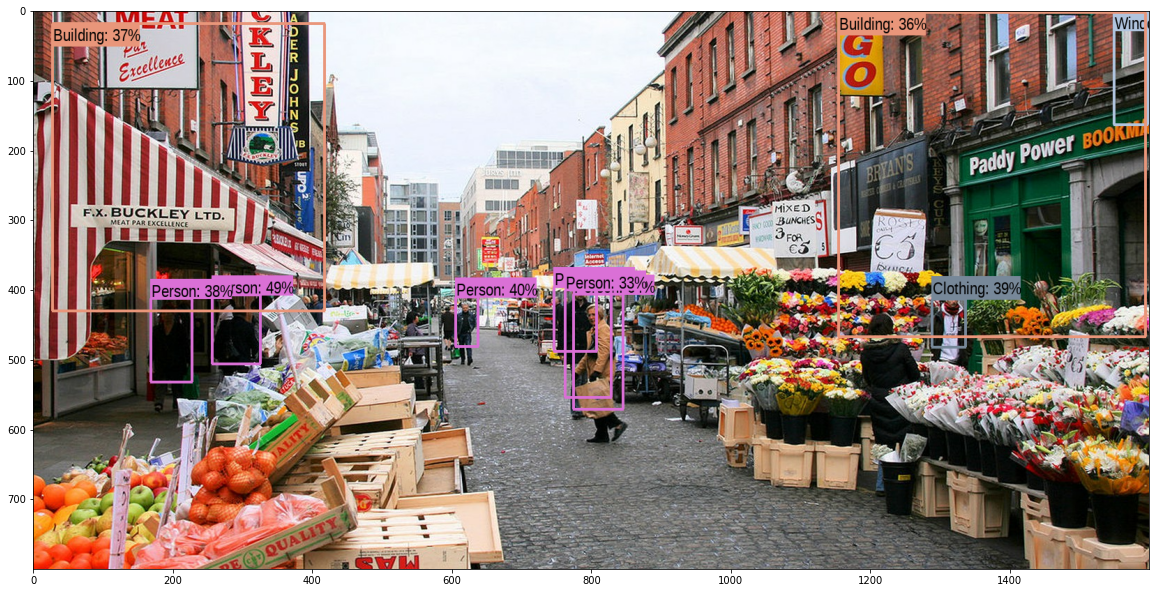

In [ ]:
box_img = predict_image("https://upload.wikimedia.org/wikipedia/commons/thumb/4/48/Moore_Street_market%2C_Dublin.jpg/1280px-Moore_Street_market%2C_Dublin.jpg" ,
                 1600 ,
                 800)

Image downloaded to /tmp/tmpk_3devdo.jpg.


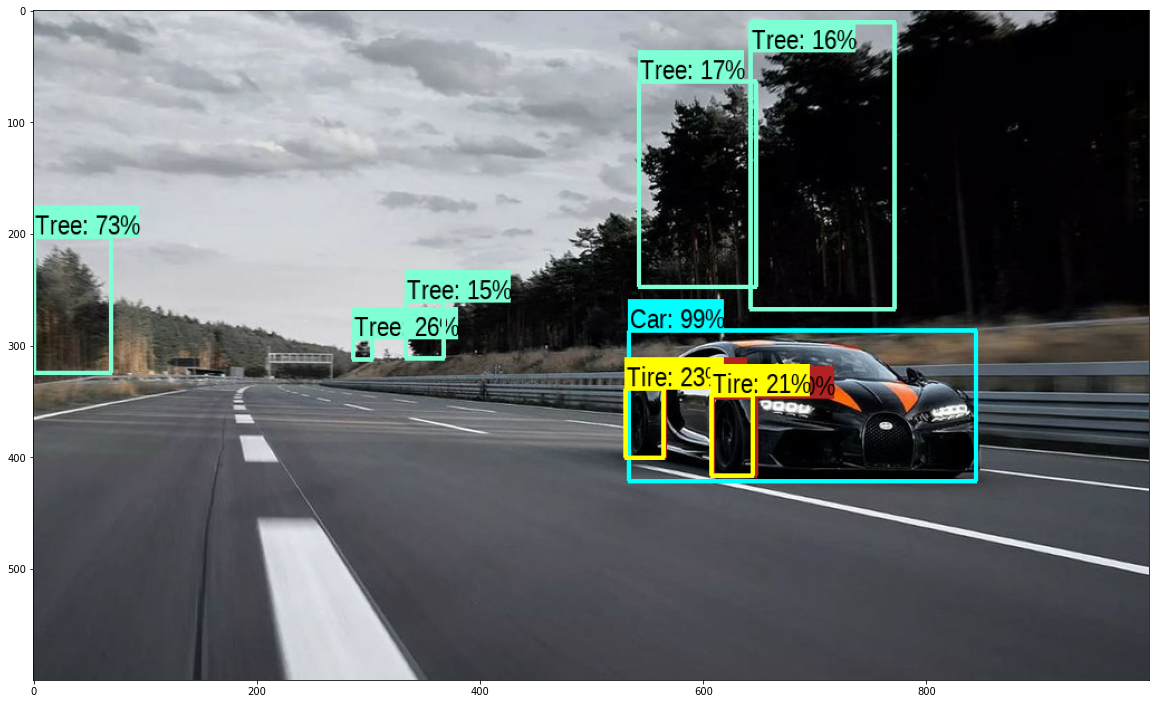

In [ ]:
def predict_on_image(img_url , width = 256 , height = 256 , show_img = True , max_boxes = 10):
    downloaded_image_path = download_and_resize_image(img_url, width, height)
    # load img and predict object label , position , accur
    img                = load_img(downloaded_image_path)
    img_pediction      = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result             = detector(img_pediction)
    result             = {key : value.numpy() for key , value in result.items()}
    box_img            = draw_boxes(img.numpy(), result["detection_boxes"],result["detection_class_entities"], result["detection_scores"] , max_boxes=max_boxes)
    if show_img:
        display_image(box_img)
    return box_img

url = "https://icdn2.themanual.com/image/themanual/bugatti-chiron-super-sport-300-coupe-2.jpg"
box_img = predict_on_image(url , 1000 , 600)